<a href="https://colab.research.google.com/github/Sri-Krishna03/data-science-vcodez/blob/main/main_project_vcodez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training samples: (193278, 30, 1)
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6040/6040 ━━━━━━━━━━━━━━━━━━━━ 200s 32ms/step - loss: 0.0036
Epoch 2/10
6040/6040 ━━━━━━━━━━━━━━━━━━━━ 205s 33ms/step - loss: 0.0025
Epoch 3/10
6040/6040 ━━━━━━━━━━━━━━━━━━━━ 204s 33ms/step - loss: 0.0024
Epoch 4/10
6040/6040 ━━━━━━━━━━━━━━━━━━━━ 199s 33ms/step - loss: 0.0025
Epoch 5/10
6040/6040 ━━━━━━━━━━━━━━━━━━━━ 202s 33ms/step - loss: 0.0025
Epoch 6/10
6040/6040 ━━━━━━━━━━━━━━━━━━━━ 202s 33ms/step - loss: 0.0025
Epoch 7/10
6040/6040 ━━━━━━━━━━━━━━━━━━━━ 201s 33ms/step - loss: 0.0024
Epoch 8/10
6040/6040 ━━━━━━━━━━━━━━━━━━━━ 198s 33ms/step - loss: 0.0024
Epoch 9/10
6040/6040 ━━━━━━━━━━━━━━━━━━━━ 197s 33ms/step - loss: 0.0024
Epoch 10/10
6040/6040 ━━━━━━━━━━━━━━━━━━━━ 198s 33ms/step - loss: 0.0024


✅ Model training completed and saved!


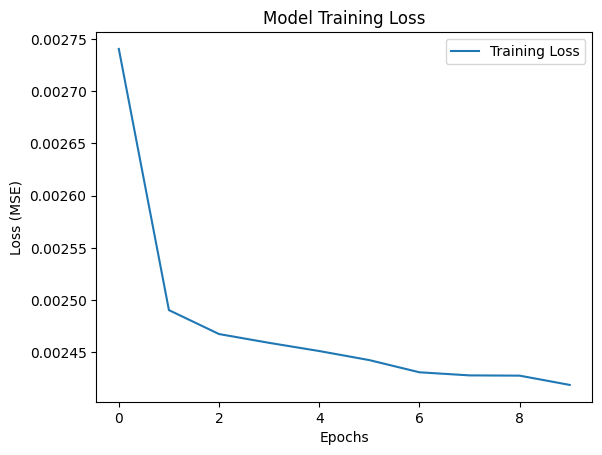

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # 0 = all logs, 1 = info, 2 = warnings, 3 = errors

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Step 1: Load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kalimati_tarkari_dataset.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Encode commodity names
le = LabelEncoder()
df["Commodity_Encoded"] = le.fit_transform(df["Commodity"])

# Save label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

# Step 2: Create sequences for all commodities
scalers = {}
window_size = 30
X, y = [], []

for commodity in df["Commodity"].unique():
    sub_df = df[df["Commodity"] == commodity][["Date", "Average"]].reset_index(drop=True)

    # Fit scaler for this commodity
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(sub_df["Average"].values.reshape(-1,1))
    scalers[commodity] = scaler

    # Create sequences
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])

# Convert to numpy arrays
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # [samples, timesteps, features]

print("Training samples:", X.shape)

# Step 3: Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1],1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")

# Step 4: Train Model
history = model.fit(X, y, epochs= 10, batch_size=32)

# Step 5: Save Model + Scalers
model.save("all_commodities_forecast.h5")
with open("scalers.pkl", "wb") as f:
    pickle.dump(scalers, f)

print("✅ Model training completed and saved!")

# Step 6: Plot Training Loss
plt.plot(history.history["loss"], label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Model Training Loss")
plt.legend()
plt.show()

# ---------------- PREDICTION PART ---------------- #

# User input for commodity
commodity = input("Enter commodity name exactly as in dataset: ")

if commodity not in scalers:
    print("❌ Commodity not found! Try again.")
else:
    sub_df = df[df["Commodity"] == commodity][["Date", "Average"]].reset_index(drop=True)
    scaler = scalers[commodity]
    scaled_data = scaler.transform(sub_df["Average"].values.reshape(-1,1))

    # Prepare sequences for prediction
    X_pred, y_true = [], []
    for i in range(window_size, len(scaled_data)):
        X_pred.append(scaled_data[i-window_size:i, 0])
        y_true.append(scaled_data[i, 0])

    X_pred = np.array(X_pred).reshape(-1, window_size, 1)
    y_true = np.array(y_true)

    # Model predictions
    pred_scaled = model.predict(X_pred)
    pred_prices = scaler.inverse_transform(pred_scaled)
    actual_prices = scaler.inverse_transform(y_true.reshape(-1,1))

    # Plot Actual vs Predicted
    plt.figure(figsize=(12,6))
    plt.plot(sub_df["Date"][window_size:], actual_prices, label="Actual Price")
    plt.plot(sub_df["Date"][window_size:], pred_prices, label="Predicted Price")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"{commodity} - Actual vs Predicted Prices")
    plt.legend()
    plt.show()

    # Predict next-day price
    last_window = scaled_data[-window_size:]
    X_test = np.array([last_window]).reshape(1, window_size, 1)
    next_day_scaled = model.predict(X_test)
    next_day_price = scaler.inverse_transform(next_day_scaled)

    print(f"📢 Next day forecast for {commodity}: {next_day_price[0][0]:.2f}")